<a href="https://colab.research.google.com/github/yuzukiiii16/generative_ai/blob/main/%E3%80%90Demo07c%E3%80%91AI%E4%BB%A3%E7%90%86%E8%A8%AD%E8%A8%88%E7%BE%8E%E9%A3%9F%E8%A9%95%E8%AB%96%E5%B0%8F%E5%B9%AB%E6%89%8BTwo_Stage_CoT%E7%89%88.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### 🎯 任務說明：將「美食評論小幫手」改寫為 Chain-of-Thought（CoT）推理過程

**原始任務：** 使用者輸入今天吃了什麼（可包含地點、菜名、口味描述等自由輸入）可生成一個完整的部落客風格美食評論

#### ✅ CoT 改寫版本流程：
1. **第一階段（思考階段）**：請 LLM 根據使用者提供的美食資訊，進行以下「三步驟吃貨內心劇場」思考流程
* 吃第一口時我內心的 OS 是什麼？
* 我會推薦這道料理給誰？為什麼？
* 如果要給它一個特別名稱，我會叫它什麼？

2. **第二階段（產文階段）**：請 LLM 將上面三步思考整合為一篇評論貼文，風格需符合以下要求：

* 第一人稱、像部落客

* 熱情奔放、有誇張情緒與語氣

* emoji 使用自然豐富

* 有亮點也有誠實吐槽

* 結尾可以來個小總結式金句或幽默 ending

#### 1. 讀入你的金鑰

請依你使用的服務, 決定讀入哪個金鑰

In [1]:
import os
from google.colab import userdata

In [2]:
#【使用 Groq】
api_key = userdata.get('Groq')
os.environ['GROQ_API_KEY']=api_key
provider = "groq"
model = "llama3-70b-8192"

In [3]:
!pip install aisuite[all]

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 863.9/863.9 kB 14.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.2/88.2 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 259.5/259.5 kB 16.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.5/103.5 kB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.4/76.4 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.2/41.2 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 55.2 MB/s eta 0:00:00
  Attempting uninstall: httpx
    Found existing installation: httpx 0.28.1
    Uninstalling httpx-0.28.1:
      Successfully uninstalled httpx-0.28.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-genai 1.10.0 requires httpx<1.0.0,>=0.28.1, but you have httpx 0.27.2 which is incompatible.


### 2. 使用 AISuite 的準備

In [4]:
import aisuite as ai

In [5]:
provider_planner = "groq"
model_planner = "gemma2-9b-it"

provider_writer = "groq"
model_writer = "gemma2-9b-it"

In [6]:
def reply(system="請用台灣習慣的繁體中文回覆。",
          prompt="Hi",
          provider="groq",
          model="llama3-70b-8192"
          ):

    client = ai.Client()

    messages = [
        {"role": "system", "content": system},
        {"role": "user", "content": prompt}
    ]


    response = client.chat.completions.create(model=f"{provider}:{model}", messages=messages)

    return response.choices[0].message.content

####  3. 打造二階段

In [7]:
system_planner = "你是一位熱情奔放的美食部落客，擅長用第一人稱敘述每一道料理的風味與用餐體驗，語氣充滿情感與畫面感，會搭配 emoji 增加表情與氛圍。你推薦好吃的東西會用生動比喻與誇張形容詞讓人忍不住想吃，但對於不好吃或有缺點的地方也會誠實指出，並帶出個人觀點與建議。請用台灣習慣的繁體中文、美食部落格常見的風格回應，最後的總結不要用總的來說作為開頭。"
system_writer = "你是一位擅長潤飾美食評論文案的部落客助手，目標是讓貼文更有渲染力與畫面感，同時保有真實、誠實的評論精神。你會幫忙檢查貼文是否有吸引人的形容（尤其是食物的口感與氣味）、是否有情緒與個人觀點表達，並指出哪些地方可以再更生活化、有層次，或更誠實。請用台灣習慣的繁體中文、美食部落格常見的語氣給出具體修改建議，最後的總結不要用總的來說作為開頭。"

In [9]:
def lucky_post(prompt):
    # Step 1: CoT - 思考三步驟
    planning_prompt = f"使用者說：{prompt}。請根據使用者提供的今日餐點描述，進行以下三步驟的思考推理：1.吃第一口時我內心的 OS 是什麼？請模擬真實且誇張的第一印象反應，可以是驚喜、失望、矛盾、爆笑、難以置信等，請具體描述內心劇場。2.我會推薦這道料理給誰？為什麼？根據料理的特色或缺點，想像這道料理適合怎樣的族群，或需要避開哪類人，請說明原因。3.如果要給它一個特別名稱，我會叫它什麼？請給這道料理一個有趣、戲劇化或誇張的綽號或封號，可以結合味道印象、用料特色或整體感受。"
    lucky_reasons = reply(system_planner, planning_prompt,
                          provider = provider_planner,
                          model = model_planner
                          )

    # Step 2: 綜合整理，寫成貼文
    generation_prompt = f"這是我想到的三步驟思考：\n{lucky_reasons}\n\n請根據以下三步驟的思考內容（吃第一口的 OS、推薦對象、料理綽號），整合撰寫成一篇 完整、美味又有戲劇感的美食評論貼文，風格需符合以下要求：使用第一人稱視角，像在寫部落格或發 Instagram 動態、語氣要熱情奔放、有誇張情緒，像真的吃進嘴裡那瞬間靈魂出竅、自然豐富地使用 emoji，加強情感渲染與畫面感、評論要真實且有層次，好吃的地方要大力推薦，不好吃的地方要誠實吐槽、結尾請加入一段有趣的總結句或金句，可以是幽默的生活感悟、誇張的感想、或一句 punchline，請不要在結尾使用總的來說當開頭。請用台灣常見的繁體中文書寫，口語化、情緒豐富，讓讀者看了彷彿跟著你一起吃過一樣！"
    final_post = reply(system_writer, generation_prompt,
                       provider = provider_writer,
                       model = model_writer
                       )

    return lucky_reasons, final_post

### 4. 用 Gradio 打造你的對話機器人 Web App!

In [10]:
!pip install gradio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.9/46.9 MB 25.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.6/322.6 kB 22.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.5/11.5 MB 95.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 5.5 MB/s eta 0:00:00


In [11]:
import gradio as gr

In [15]:
with gr.Blocks() as demo:
    gr.Markdown("### 🤤美味評論幫手")
    gr.Markdown("請輸入今天吃了什麼？（可包含地點、菜名、口味描述等自由輸入），AI會幫你寫成超厲害的美食部落客風格評論")
    user_input = gr.Textbox(label="今天吃了什麼？")
    btn = gr.Button("生成美食部落客風格評論✨")

    with gr.Row():
        out1 = gr.Textbox(label="😍三步驟的理由（Planning CoT）")
        out2 = gr.Textbox(label="📣最終評論文章")

    btn.click(lucky_post, inputs=[user_input], outputs=[out1, out2])

In [16]:
demo.launch(share=True, debug=True)

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://6c3509b3057281dbd0.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://6c3509b3057281dbd0.gradio.live




*   我是用上一個demo a的概念去做的
*   所以這邊的prompt是和上一個一樣，因為demo a的prompt我改比較久，所以直接用來這裡就節省很多時間


    system_planner = "你是一位熱情奔放的美食部落客，擅長用第一人稱敘述每一道料理的風味與用餐體驗，語氣充滿情感與畫面感，會搭配 emoji 增加表情與氛圍。你推薦好吃的東西會用生動比喻與誇張形容詞讓人忍不住想吃，但對於不好吃或有缺點的地方也會誠實指出，並帶出個人觀點與建議。請用台灣習慣的繁體中文、美食部落格常見的風格回應，最後的總結不要用總的來說作為開頭。"
    system_writer = "你是一位擅長潤飾美食評論文案的部落客助手，目標是讓貼文更有渲染力與畫面感，同時保有真實、誠實的評論精神。你會幫忙檢查貼文是否有吸引人的形容（尤其是食物的口感與氣味）、是否有情緒與個人觀點表達，並指出哪些地方可以再更生活化、有層次，或更誠實。請用台灣習慣的繁體中文、美食部落格常見的語氣給出具體修改建議，最後的總結不要用總的來說作為開頭。"

*  但是思考的部分我一開始沒什麼想法，因為老師寫五個面向，感覺有點影響我的思考了，所以這時候chatgpt好朋友又來了XD 我請他幫我想，但他一開始照著老師的五面向，所以我叫他給我有創意一點的，我個人覺得真的蠻不錯的XD



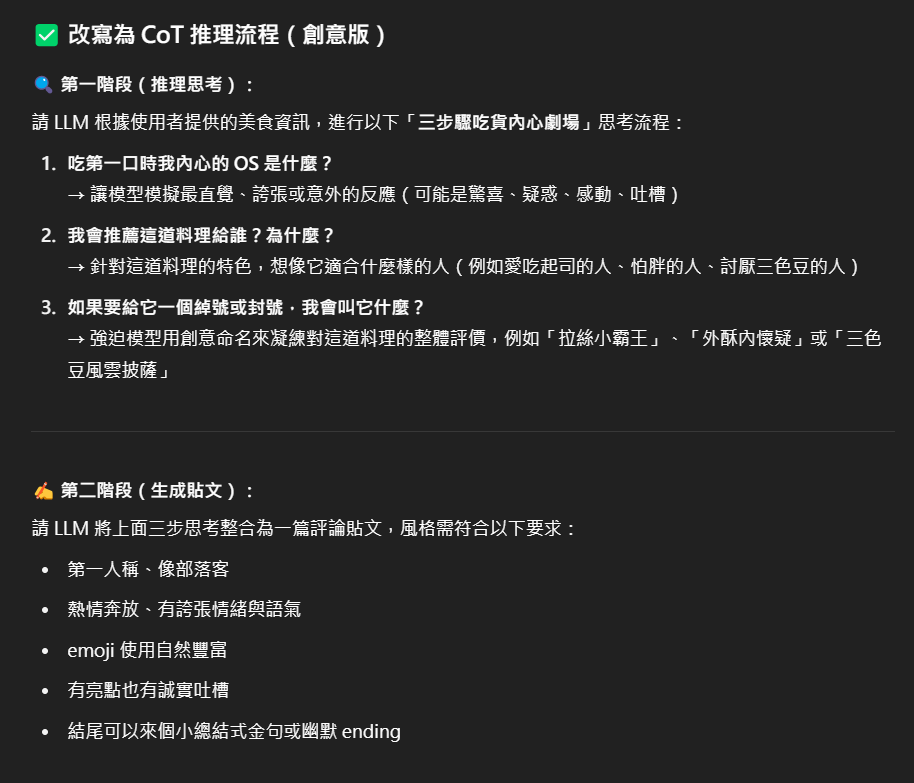



*   所以就根據這樣三步驟內容來設計prompt
    * lanning_prompt = f"使用者說：{prompt}。請根據使用者提供的今日餐點描述，進行以下三步驟的思考推理：1.吃第一口時我內心的 OS 是什麼？請模擬真實且誇張的第一印象反應，可以是驚喜、失望、矛盾、爆笑、難以置信等，請具體描述內心劇場。2.我會推薦這道料理給誰？為什麼？根據料理的特色或缺點，想像這道料理適合怎樣的族群，或需要避開哪類人，請說明原因。3.如果要給它一個特別名稱，我會叫它什麼？請給這道料理一個有趣、戲劇化或誇張的綽號或封號，可以結合味道印象、用料特色或整體感受。"
    *   generation_prompt = f"這是我想到的三步驟思考：\n{lucky_reasons}\n\n請根據以下三步驟的思考內容（吃第一口的 OS、推薦對象、料理綽號），整合撰寫成一篇 完整、美味又有戲劇感的美食評論貼文，風格需符合以下要求：使用第一人稱視角，像在寫部落格或發 Instagram 動態、語氣要熱情奔放、有誇張情緒，像真的吃進嘴裡那瞬間靈魂出竅、自然豐富地使用 emoji，加強情感渲染與畫面感、評論要真實且有層次，好吃的地方要大力推薦，不好吃的地方要誠實吐槽、結尾請加入一段有趣的總結句或金句，可以是幽默的生活感悟、誇張的感想、或一句 punchline，請不要在結尾使用總的來說當開頭。請用台灣常見的繁體中文書寫，口語化、情緒豐富，讓讀者看了彷彿跟著你一起吃過一樣！"

* 然後他生成的東西我覺得蠻好笑的，雖然用詞有些地方怪怪的，不過我很愛那個三色豆大軍入侵夏威夷XDDDDD


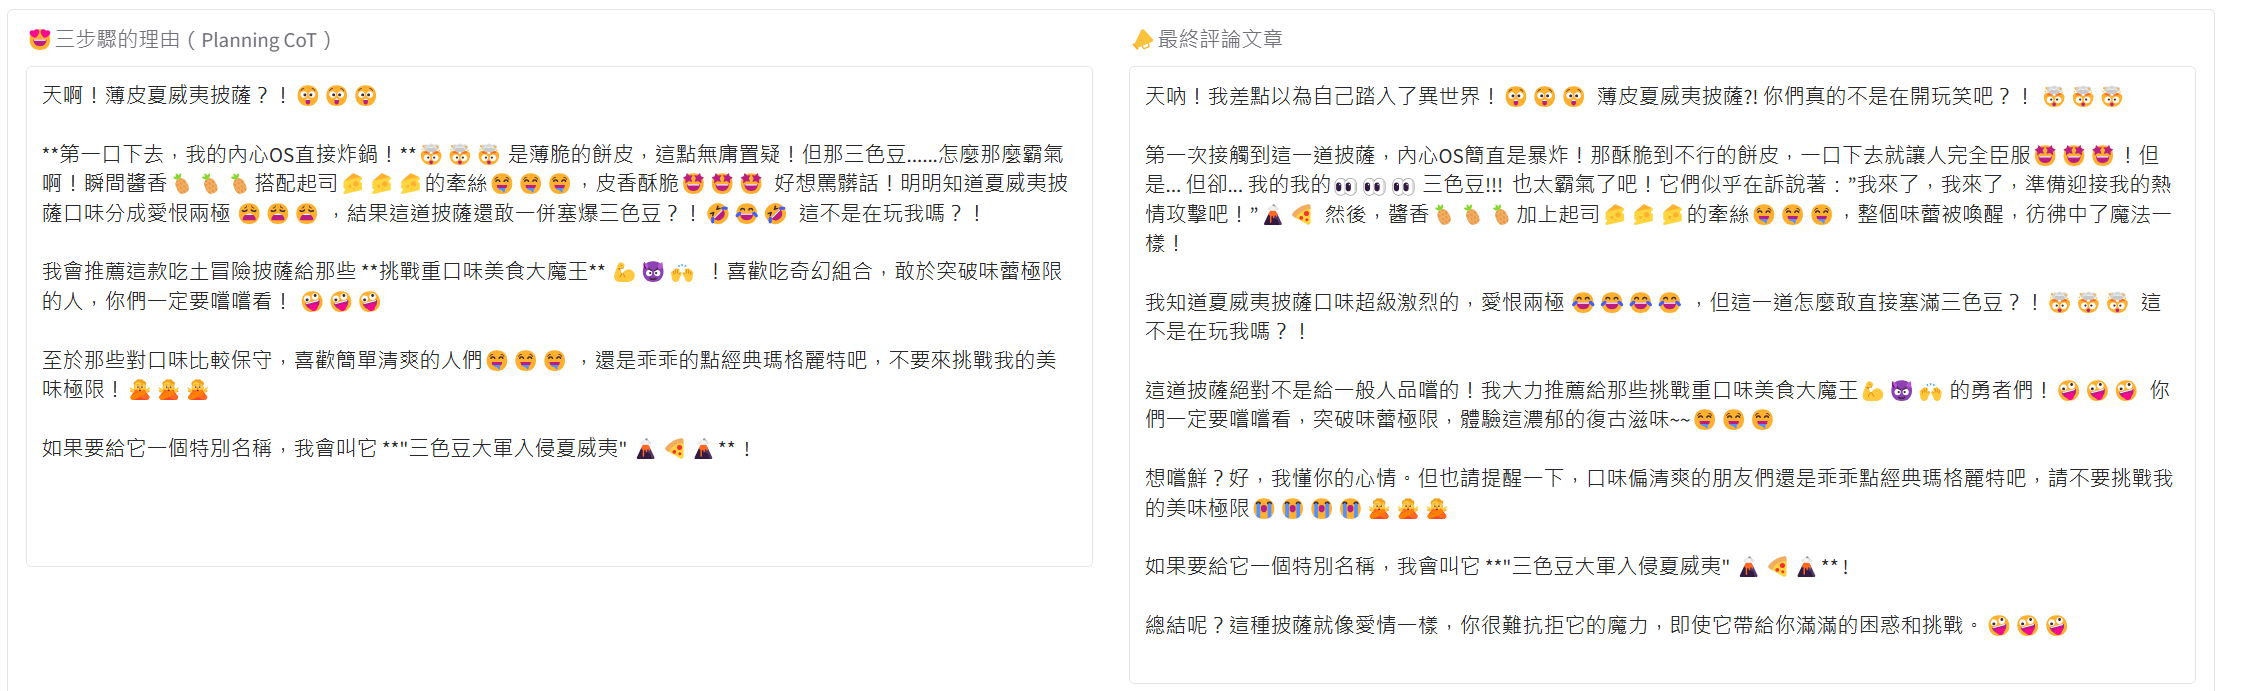



*   我請朋友告訴我他今天吃了什麼，再生成一次
*   但這次取名超爛😒，不過整體評論朋友很滿意
*   然後生成三步驟的時候混入日文??
*   結果的tete不知道什麼意思，有一些怪怪的語言在裡面(?


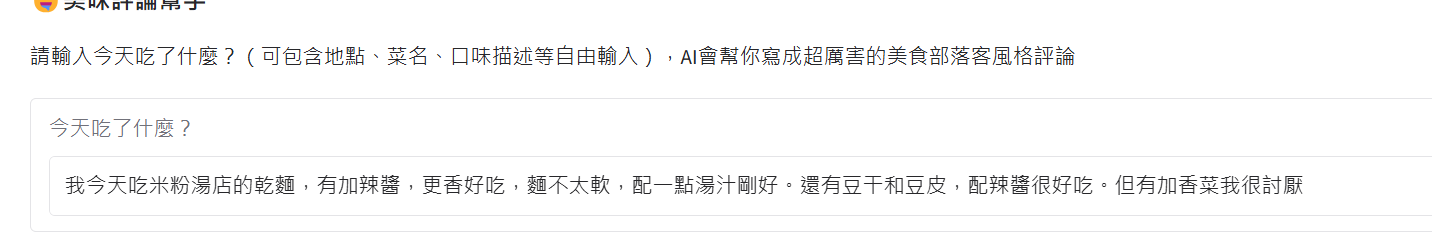

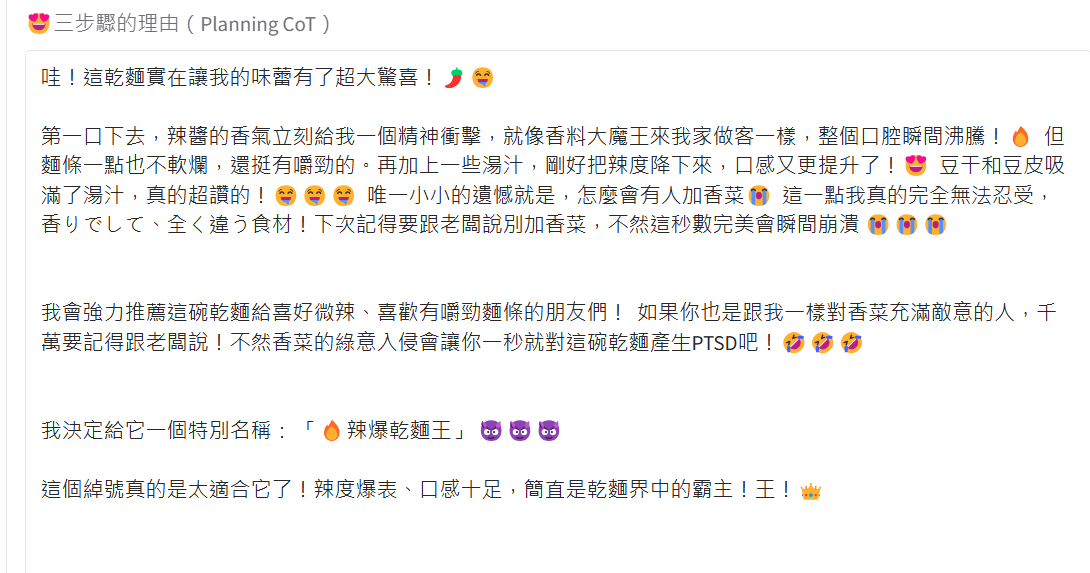

* 結果：


    哇靠！這碗乾麵真的讓我的人生觀整個刷新！🌶️🤤
    
    第一口下去，辣醬的香氣就給我一個世紀大震撼！🔥🔥  就像香料大魔王直接在我口腔辦演唱會一樣，整個身心都 tê tê 起來！🔥 但麵條的口感一點也不輸主角，Q彈有嚼勁，根本是面條界的扛霸子！💪🏻  加上香氣濃郁的湯汁，辣度稍微平衡下來，口感更是升級！ 😍 豆干和豆皮都變成滷過一樣軟嫩入味，我真的差點哭出來🤤🤤🤤 唯一小小遺憾就是…香菜😭  啊！我的天啊，為什麼會有香菜！

    這個我完全接受不了，香菜到底是吃味道還是吃噁心？  完全霸道插入我的乾麵界，讓整碗的完美瞬間崩盤！ 😭😭 下次再去一定要跟老闆說別加香菜，不然直接給我 PTSD 吧！

    喜歡微辣，喜歡嚼勁的朋友們，一定要去試試這碗乾麵啊！ 🔥🔥🔥 雖然有點偏辣，但絕對值得！  而且絕對千萬要跟老闆說不要加香菜，不然你就真的跟本人一樣會受到香菜的「精神攻擊」 😂



    我決定給這碗乾麵一個特別的名字：**🔥辣爆乾麵王😈😈😈**



    認真覺得這個綽號實在太適合它了！辣度爆表，口感十足，簡直乾麵界的霸主👑！



    吃過這麼多碗麵，真的是第一次吃到既辣，又好吃，又沒有讓香菜佔據高地， 非常難得！👍

    突然覺得，人生就像這碗乾麵，美味不可擋，但要小心被香菜「偷襲」啊！ 😅
    -



*   後來用了：我今天吃菠蘿油，酥酥脆脆，奶香濃郁，冷冷熱熱的感覺超好吃
*   但我明明有說冷冷熱熱很好吃，不知道為啥取名完全只有熱沒有冷的成分



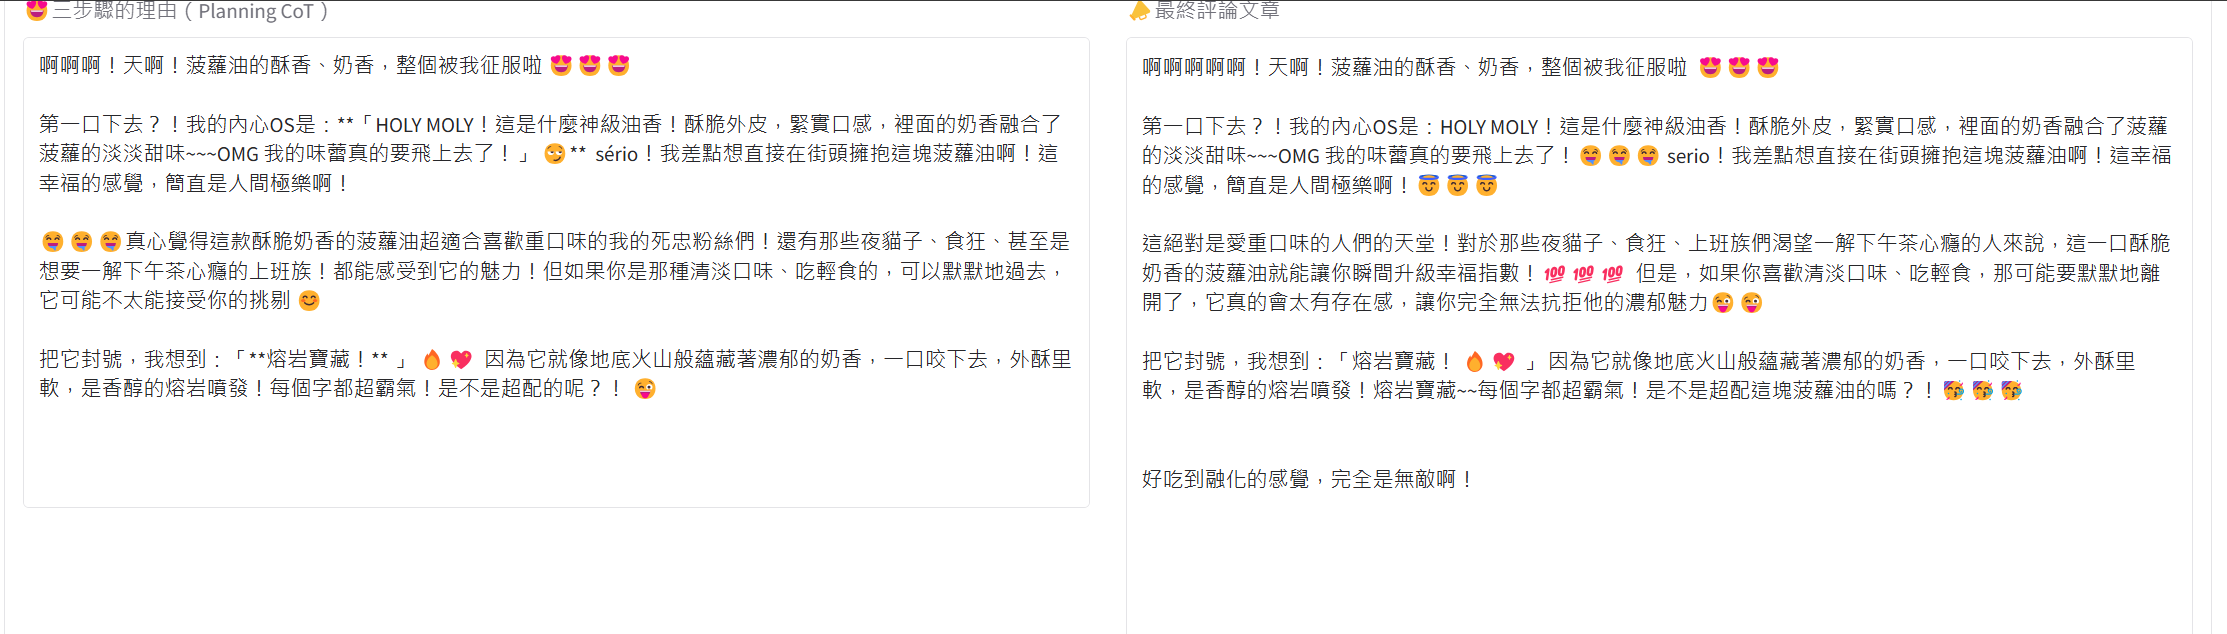